# Introduction
This notebook is testing how  μMerge handles ChIP-seq replicates in comparison to other merging techniques such as bedtools merge and bedtools intersect.


# ENCODE ChIP Processing Pipeline

## REST ChIP data

The encode data was processed using the hg19 genome.

MCF7 REST ChIP-seq data  \[2 replicates \]: https://www.encodeproject.org/experiments/ENCSR000BSP/



## Motif scanning with FIMO

- Transcription Motifs were scanned for based summit locations for each peak call

```sh
fimo -max-stored-scores 1000000 --thresh 1e-4 -oc ${outdir}/${bed} -motif $motiffile ${hocomoco}/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ${chip_fa}/${bed}_mac\
s.fa
```

## Merging Regions

- bedtools merge
- bedtools intersect
- mumerge

# Load libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/rusi2317/projects/mumerge_test/bin/mumerge_explore'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
pkg_dir='/Users/rusi2317/.local/lib/python3.6/site-packages/'
sys.path.append(os.path.abspath(pkg_dir))

In [2]:
import time
import seaborn as sns
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from mumerge_explore.load_data import *
from mumerge_explore.plot_figures import *
from mumerge_explore.process_regions import *

## Filtering regions for merging

In [4]:
rest_samples = ['ENCFF001UEC','ENCFF001UED',
                'ENCFF001UNH','ENCFF001UNI']

motif = '/Users/rusi2317/projects/mumerge_test/encode_rest/processed_data/fimo_scans/'
peaks = '/Users/rusi2317/projects/mumerge_test/data/encode_peak_calls/'
outdir = '/Users/rusi2317/projects/mumerge_test/encode_rest/processed_data/significant_regions/'

for sample_name in rest_samples:
    
    fimo_hits = load_fimo(motif+sample_name+'.bed/fimo.tsv')

    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)

    fimo_filtered_unique = unique_sig_fimo(fimo_filtered)

    fimo_sig_summit_peaks = sig_summit_peaks(peaks+sample_name+'.bed_summits.bed',
                                              fimo_filtered_unique)

    fimo_sig_narrow_peaks = final_narrow_peaks(peaks+sample_name+'.bed',
                                                fimo_sig_summit_peaks, outdir,sample_name+'_sigFimo.bed' )
    print(' ')

---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 2730
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
------------------------- UNIQUE FIMO HITS --------------------------
-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------
-> Macs peaks called = 2735
---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------
-> Peaks with significant hits = 1690
------------------- DONE RUNNING ENCFF001UEC_sigFimo.bed -------------------
---------------------------------------------------------------------
 
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 3186
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
------------------------- UNIQUE FIMO HITS --------------------------
-------------- SIGNIFICAN

## Comparing region widths 

In [5]:
##this will load the bed files and also get the region centers
mumerged_mcf7 = fetch_merged_regions('/Users/rusi2317/projects/mumerge_test/encode_rest/processed_data/merged_regions/mcf7_mumerged.bed_MUMERGE.bed')
btmerged_mcf7 = fetch_merged_regions('/Users/rusi2317/projects/mumerge_test/encode_rest/processed_data/merged_regions/MCF7_merged.bed')
interset_mcf7 = fetch_merged_regions('/Users/rusi2317/projects/mumerge_test/encode_rest/processed_data/merged_regions/MCF7_intersect.bed')

In [6]:
##get list of samples for MCF7 samples
bed_files_encode = '/Users/rusi2317/projects/mumerge_test/data/encode_peak_calls/'

samples_encode =  []

for bed in os.listdir(bed_files_encode):
    if bed.endswith('UNI.bed'):
        samples_encode.append(bed_files_encode + bed)
    elif bed.endswith('UNH.bed'):
        samples_encode.append(bed_files_encode + bed)
    else:
        pass

In [7]:
fetched_regions_en = []
region_ids_en = []

for path in samples_encode:
    print(path)
    region = fetch_merged_regions(path)
    sample_id = str.split(str(path),'/')[-1]
    fetched_regions_en.append(region)
    region_ids_en.append(sample_id)

/Users/rusi2317/projects/mumerge_test/data/encode_peak_calls/ENCFF001UNI.bed
/Users/rusi2317/projects/mumerge_test/data/encode_peak_calls/ENCFF001UNH.bed


In [8]:
fetched_regions_encode = fetched_regions_en + [btmerged_mcf7] + [interset_mcf7] + [mumerged_mcf7] 
region_ids_encode = region_ids_en + ['Bedtools Merge', 'Bedtools Intersect', r'$\mu$Merge']

(array([ 0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,  0.003 ]),
 <a list of 7 Text yticklabel objects>)

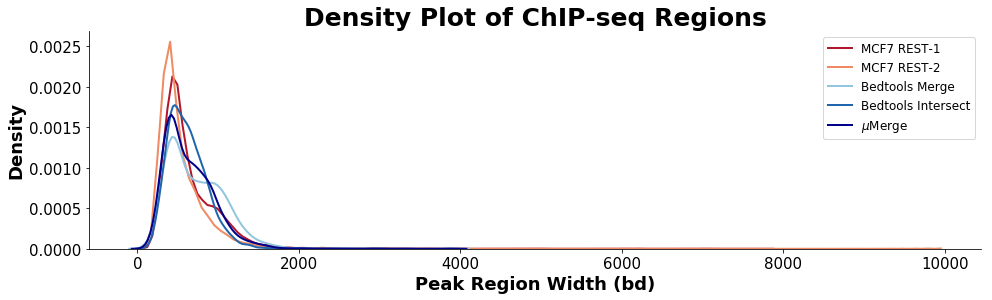

In [9]:
plt.figure(figsize=(16,4))

sns.set_palette(sns.cubehelix_palette(9))

line_col = ['#b2182b','#ef8a62','#92c5de','#2166ac','darkblue']

for regions, ids, cols in zip(fetched_regions_encode, ['MCF7 REST-1','MCF7 REST-2',
                                                 'Bedtools Merge',
                                                 'Bedtools Intersect',r'$\mu$Merge'],line_col):
    
    ax00 = sns.distplot(regions, hist=False, kde=True,
                 bins=60, color = cols,
                 kde_kws={'shade': False,'linewidth': 2},
                 label=str(ids))
    ax00.spines['right'].set_visible(False)
    ax00.spines['top'].set_visible(False)
    
plt.legend(prop={'size': 12}, title = '')
plt.title('Density Plot of ChIP-seq Regions',fontsize=25,fontweight='bold')
plt.xlabel('Peak Region Width (bd)',fontsize=18,fontweight='bold')
plt.ylabel('Density',fontsize=18,fontweight='bold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

/opt/jupyterhub/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


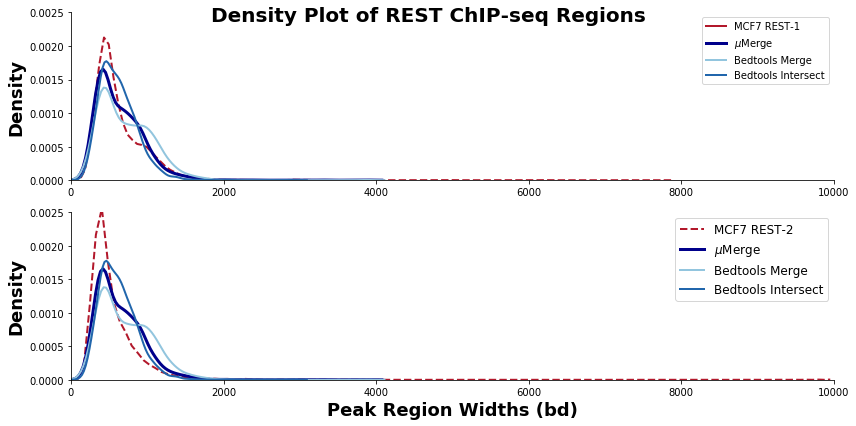

In [10]:
region_ids_encode_mcf7 = ['MCF7 REST-1', 'MCF7 REST-2']

fig, axs = plt.subplots(nrows=2, figsize=(12,6))

for i in range(len(fetched_regions_encode[0:2])):

        
        ax = sns.distplot(fetched_regions_encode[i], hist=False, kde=True,rug = False, 
                     bins=60, color = '#b2182b', 
                     kde_kws={'shade': False,'linewidth': 2},
                     rug_kws={'color': '#b2182b'},
                     label=str(region_ids_encode_mcf7[i]),
                    ax=axs[i])
        
        ax = sns.distplot(mumerged_mcf7, hist=False, kde=True,rug = False, 
                     bins=60, color = 'darkblue', 
                     kde_kws={'shade': False,'linewidth': 3},
                    rug_kws={'color': 'darkblue'},
                    label=r'$\mu$Merge',
                     ax=axs[i])

        ax = sns.distplot(btmerged_mcf7, hist=False, kde=True,rug = False, 
                     bins=60, color = '#92c5de', 
                     kde_kws={'shade': False,'linewidth': 2},
                    rug_kws={'color': '#92c5de'},
                    label='Bedtools Merge',
                     ax=axs[i])

        ax = sns.distplot(interset_mcf7, hist=False, kde=True,rug = False, 
                     bins=60, color = '#2166ac', 
                     kde_kws={'shade': False,'linewidth': 2},
                    rug_kws={'color': '#2166ac'},
                    label='Bedtools Intersect',
                     ax=axs[i])

        ax.lines[0].set_linestyle("--")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(prop={'size': 12}, title = '')
        plt.xlabel('Peak Region Widths (bd)',fontsize=18,fontweight='bold')
        ax.set_ylabel('Density',fontsize=18,fontweight='bold')
        ax.set(xlim=(0, 10000))
        ax.set(ylim=(0, 0.0025))

fig.suptitle('Density Plot of REST ChIP-seq Regions',fontsize=20,fontweight='bold')
fig.tight_layout()
fig.show()

/opt/jupyterhub/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


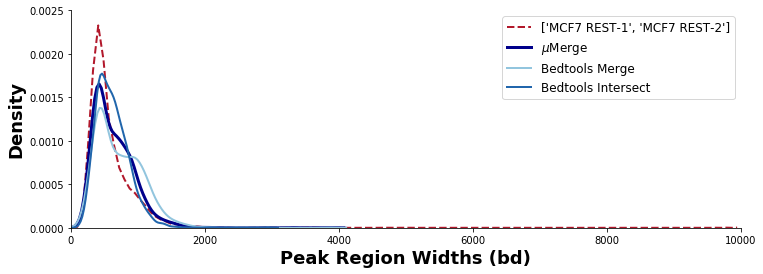

In [33]:
fig, ax_comb = plt.subplots(figsize=(12,4))
combined_samples = [j for i in fetched_regions_en for j in i]


ax_comb = sns.distplot(combined_samples, hist=False, kde=True,rug = False, 
                  bins=60, color = '#b2182b', 
                  kde_kws={'shade': False,'linewidth': 2},
                  rug_kws={'color': '#b2182b'},
                  label=str(region_ids_encode_mcf7))

ax_comb = sns.distplot(mumerged_mcf7, hist=False, kde=True,rug = False, 
                       bins=60, color = 'darkblue', 
                       kde_kws={'shade': False,'linewidth': 3},
                       rug_kws={'color': 'darkblue'},
                       label=r'$\mu$Merge')

ax_comb = sns.distplot(btmerged_mcf7, hist=False, kde=True,rug = False, 
                       bins=60, color = '#92c5de', 
                       kde_kws={'shade': False,'linewidth': 2},
                       rug_kws={'color': '#92c5de'},
                       label='Bedtools Merge')

ax_comb = sns.distplot(interset_mcf7, hist=False, kde=True,rug = False, 
                       bins=60, color = '#2166ac', 
                       kde_kws={'shade': False,'linewidth': 2},
                       rug_kws={'color': '#2166ac'},
                       label='Bedtools Intersect')

ax_comb.lines[0].set_linestyle("--")
ax_comb.spines['right'].set_visible(False)
ax_comb.spines['top'].set_visible(False)
ax_comb.set_ylabel('Density',fontsize=18,fontweight='bold')
ax_comb.set(xlim=(0, 10000))
ax_comb.set(ylim=(0, 0.0025))

plt.legend(prop={'size': 12}, title = '')
plt.xlabel('Peak Region Widths (bd)',fontsize=18,fontweight='bold')
#fig.suptitle('Density Plot of REST ChIP-seq Regions',fontsize=20,fontweight='bold')
#fig.tight_layout()
fig.show()

### Kullback-Liebler Divergence 

In [11]:
##using the bin edges from the mumerge regions
counts_en, bin_edges_en = np.histogram(mumerged_mcf7, bins=60, density=True)

region_densities_en = []

for regions, ids in zip(fetched_regions_encode, region_ids_encode):
    
    cnt, bns = np.histogram(regions, bins=bin_edges_en, density=True)
    region_densities_en.append(cnt)

In [12]:
## Kullback-Liebler Divergence 
kl_results_en = []
kl_labels_en = []
for dens0, ids0 in zip(region_densities_en, region_ids_encode):
    for dens1, ids1 in zip(region_densities_en, region_ids_encode):
        
        constant = float(1e-30)
        kl = entropy(dens0+constant, dens1+constant, base=10)
        kl_results_en.append(float(kl))
        kl_labels_en.append([ids0, ids1])

In [13]:
n=5
x_en = np.array([kl_results_en[i:i + n] for i in range(0, len(kl_results_en), n)])  
print(x_en) 

[[ 0.          0.06064845  0.1213377   0.22885395  0.12172959]
 [ 0.07948754  0.          0.18771652  0.30643664  0.17064402]
 [ 0.07281686  0.10357472  0.          0.23305262  0.08077062]
 [ 0.03417208  0.08264028  0.07075982  0.          0.03514287]
 [ 0.04158395  0.04812088  0.04960891  0.13576177  0.        ]]


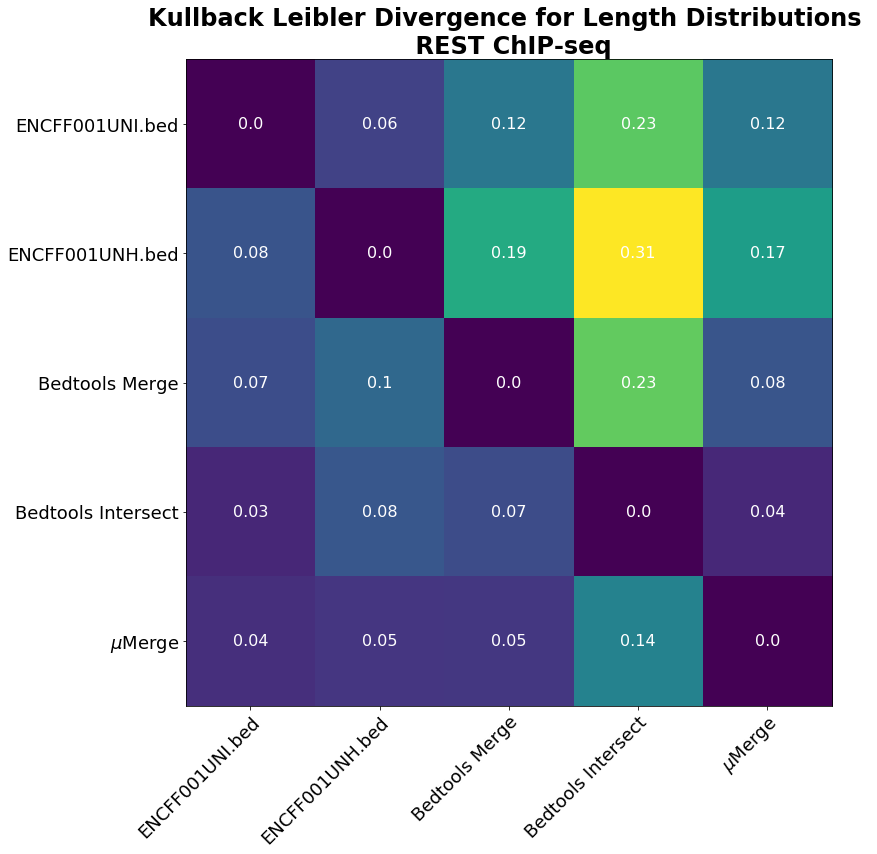

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(x_en)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n REST ChIP-seq",
            fontsize=24,fontweight='bold')

ax.set_xticks(np.arange(len(region_ids_encode)))
ax.set_yticks(np.arange(len(region_ids_encode)))

ax.set_xticklabels(region_ids_encode,fontsize=18)
ax.set_yticklabels(region_ids_encode,fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(region_ids_encode)):
    for j in range(len(region_ids_encode)):
        text = ax.text(j, i, round(x_en[i, j],2),
                       ha="center", va="center", color="w",
                       fontsize=16)

fig.tight_layout()
plt.show()

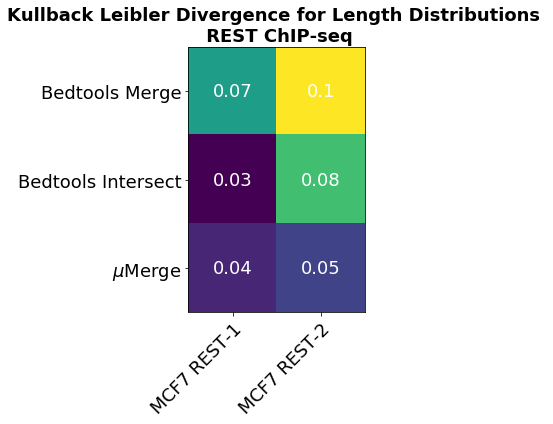

In [15]:
##filter mumerge comparisons with the samples
merge_kl = x_en[2:6,0:2]

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(merge_kl)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n REST ChIP-seq",
            fontsize=18,fontweight='bold')

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(3))

ax.set_xticklabels(region_ids_encode_mcf7,fontsize=18)
ax.set_yticklabels(region_ids_encode[2:5],fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(3):
    for j in range(2):
        text = ax.text(j, i, round(merge_kl[i, j],2),
                       ha="center", va="center", color="w",
                       fontsize=18)

fig.tight_layout()
plt.show()

In [45]:
combined_regions_encode = [combined_samples] + [btmerged_mcf7] + [interset_mcf7] + [mumerged_mcf7] 
combined_ids_encode = ['Combined Replicates','Bedtools Merge', 'Bedtools Intersect', r'$\mu$Merge']

##using the bin edges from the mumerge regions
counts_en, bin_edges_en = np.histogram(mumerged_mcf7, bins=60, density=True)

combined_region_densities_en = []

for regions, ids in zip(combined_regions_encode, combined_ids_encode):
    
    cnt, bns = np.histogram(regions, bins=bin_edges_en, density=True)
    combined_region_densities_en.append(cnt)

In [46]:
## Kullback-Liebler Divergence 
kl_results_comb = []
kl_labels_comb = []
for dens0, ids0 in zip(combined_region_densities_en, combined_ids_encode):
    for dens1, ids1 in zip(combined_region_densities_en, combined_ids_encode):
        
        constant = float(1e-30)
        kl = entropy(dens0+constant, dens1+constant, base=10)
        kl_results_comb.append(float(kl))
        kl_labels_comb.append([ids0, ids1])

In [47]:
n=4
x_comb = np.array([kl_results_comb[i:i + n] for i in range(0, len(kl_results_comb), n)])  
print(x_comb) 

[[ 0.          0.14740506  0.2610465   0.1382491 ]
 [ 0.06029401  0.          0.23305262  0.08077062]
 [ 0.04615845  0.07075982  0.          0.03514287]
 [ 0.02650598  0.04960891  0.13576177  0.        ]]


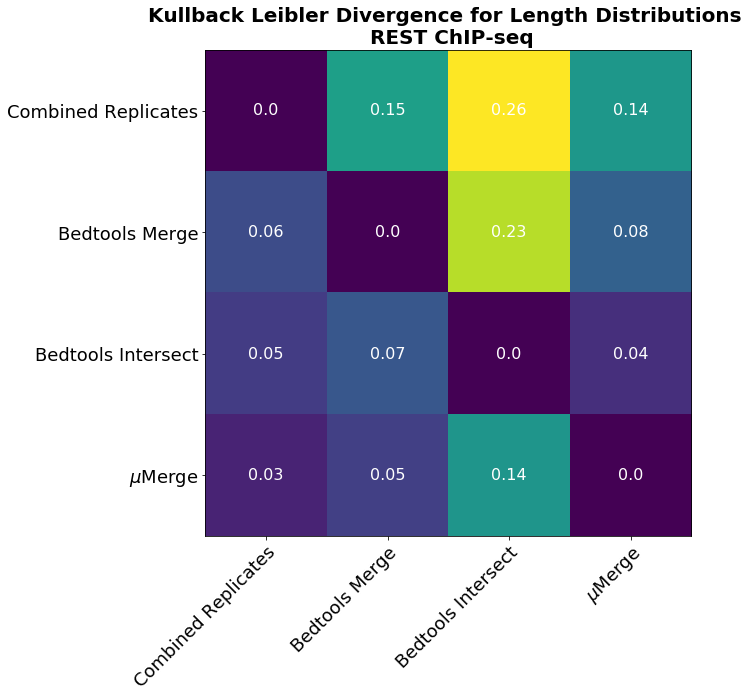

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x_comb)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n REST ChIP-seq",
            fontsize=20,fontweight='bold')

ax.set_xticks(np.arange(len(combined_ids_encode)))
ax.set_yticks(np.arange(len(combined_ids_encode)))

ax.set_xticklabels(combined_ids_encode,fontsize=18)
ax.set_yticklabels(combined_ids_encode,fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(combined_ids_encode)):
    for j in range(len(combined_ids_encode)):
        text = ax.text(j, i, round(x_comb[i, j],2),
                       ha="center", va="center", color="w",
                       fontsize=16)

fig.tight_layout()
plt.show()

## Surveying Motif - Summit distances

In [16]:
##individual samples
encode_samples = ['ENCFF001UNH.bed','ENCFF001UNI.bed']

sample_narrow = '/scratch/Users/rusi2317/projects/encode_mumerge_test/rest/raw_data/' 
sample_fimo = '/scratch/Users/rusi2317/projects/encode_mumerge_test/rest/processed_data/fimo_scans_whole_seq/'

sample_distances = []

for sample_name in encode_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    macs_results = load_bed(sample_narrow + sample_name)
    macs_summit = load_bed(sample_narrow + sample_name + '_summits.bed')
    fimo_hits = load_fimo(sample_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist = summit_motif_dist(macs_results, macs_summit, fimo_filtered_unique)
    
    sample_distances.append(motif_peak_dist)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......ENCFF001UNH.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 7202
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 2502
.....DONE processing.....ENCFF001UNH.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......ENCFF001UNI.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 5287
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 2019
.....DONE processing.....ENCFF001UNI.bed
---------------------------------------------------------------------
 


In [17]:
##merged regions
merge_samples = ['MCF7_intersect.bed',
                 'MCF7_merged.bed',
                 'mcf7_mumerged.bed_MUMERGE.bed']

summary_narrow = '/scratch/Users/rusi2317/projects/encode_mumerge_test/rest/processed_data/merged_regions/' 
summary_fimo = '/scratch/Users/rusi2317/projects/encode_mumerge_test/rest/processed_data/fimo_scans_whole_seq/' 

merge_distances = []
merge_motif_sig = []

for sample_name in merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(summary_narrow + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(summary_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig = summit_motif_dist(merged_narrow, merged_summit, fimo_filtered_unique)
    
    merge_distances.append(motif_peak_dist)
    merge_motif_sig.append(motif_sig)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......MCF7_intersect.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 2761
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 1930
.....DONE processing.....MCF7_intersect.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......MCF7_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 3929
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 2623
.....DONE processing.....MCF7_merged.bed
---------------------------------------------------------------------
 
--

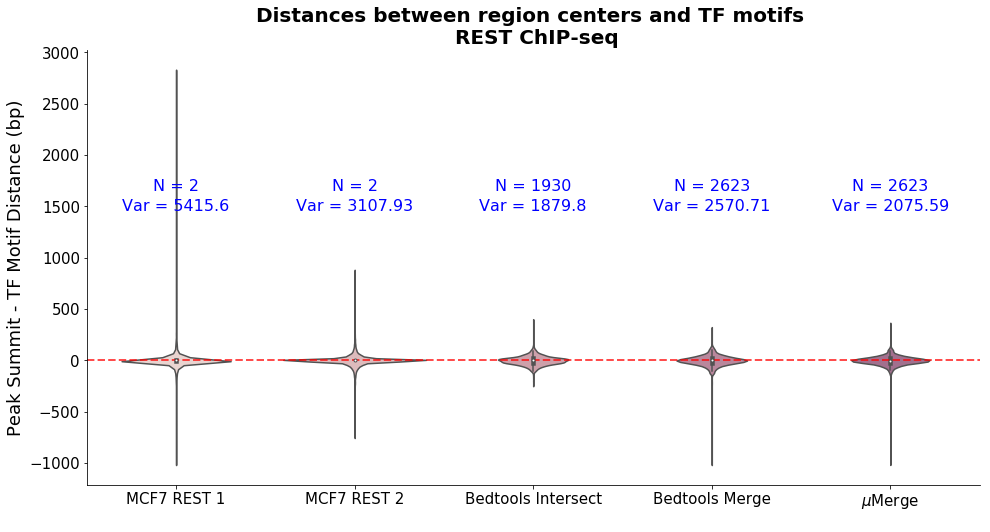

In [18]:
total_distances = sample_distances + merge_distances

variance = []

for v in total_distances:
    var = np.var(v)
    variance.append(var)
    
for s in total_distances:
    std = np

total_ids = ['MCF7 REST 1','MCF7 REST 2',
             'Bedtools Intersect', 
            'Bedtools Merge',
            r'$\mu$Merge']

fig, ax05 = plt.subplots(figsize=(16, 8))

ax05 = sns.violinplot(data=total_distances, cut=0, inner='box')
ax05.axhline(0, ls='--', color='red', linewidth=2, alpha=.7)
ax05.set_xticklabels(total_ids)

ax05.set_title('Distances between region centers and TF motifs \n REST ChIP-seq',
             fontsize=20, fontweight='bold')
ax05.set_xlabel(' ')
ax05.set_ylabel('Peak Summit - TF Motif Distance (bp)',fontsize=18)
ax05.spines['right'].set_visible(False)
ax05.spines['top'].set_visible(False)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0,1,2,3,4], variance, total_distances):
    text = ax05.text(i, 1700, 'N = ' + str(len(k)),
                        ha="center", va="center", color="blue",
                        fontsize=16)
    text = ax05.text(i, 1500, 'Var = ' + str(round(j, 2)),
                       ha="center", va="center", color="blue",
                       fontsize=16)

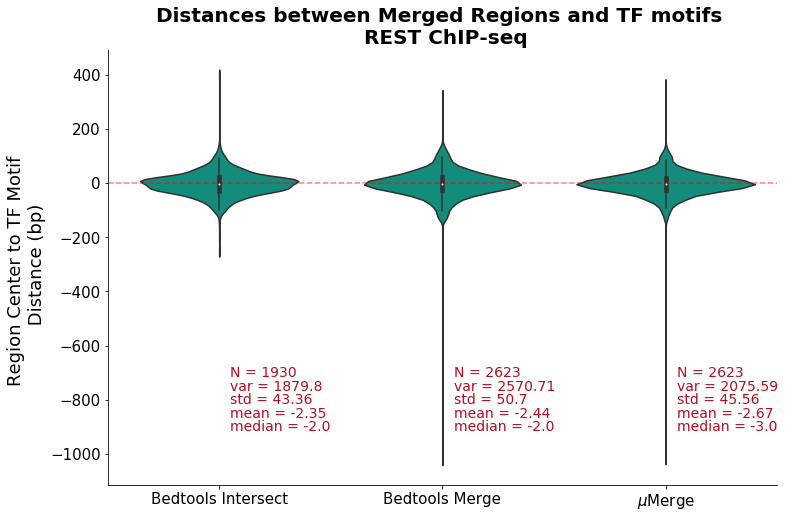

In [39]:
fig, ax06 = plt.subplots(figsize=(12, 8))

ax06 = sns.violinplot(data=total_distances[2:], inner='box',color="#00A08A") 
ax06.axhline(0, ls='--', color='red', linewidth=1.5, alpha=.5)
ax06.set_xticklabels(total_ids[2:])

ax06.set_title('Distances between Merged Regions and TF motifs \n REST ChIP-seq',
             fontsize=20, fontweight='bold')
ax06.set_xlabel(' ')
ax06.set_ylabel('Region Center to TF Motif \n Distance (bp)',fontsize=18)

ax06.spines['right'].set_visible(False)
ax06.spines['top'].set_visible(False)
plt.legend(prop={'size': 12}, title = '')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0.05,1.05,2.05], variance[2:], [2,3,4]):
    text = ax06.text(i, -700, 'N = ' + str(len(total_distances[k])),
                        ha="left", va="center", color="#B40F20",
                        fontsize=14)
    text = ax06.text(i, -750, 'var = ' + str(round(j, 2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -800, 'std = ' + str(round(np.std(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -850, 'mean = ' + str(round(np.mean(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -900, 'median = ' + str(round(np.median(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)

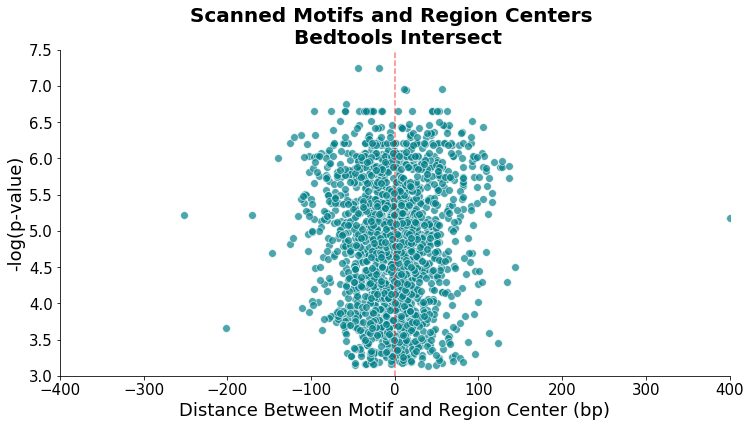

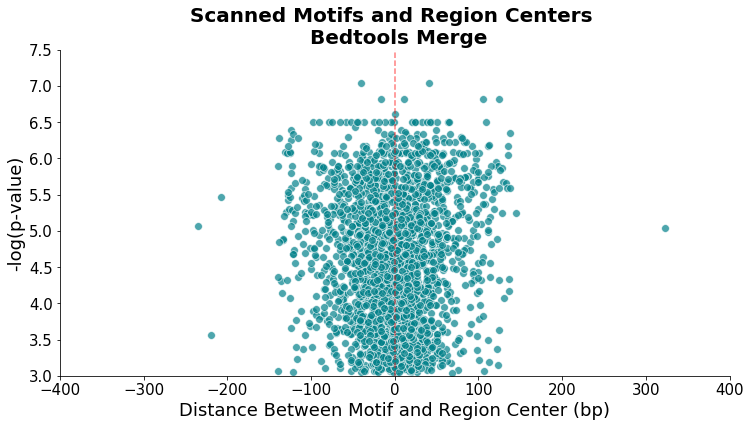

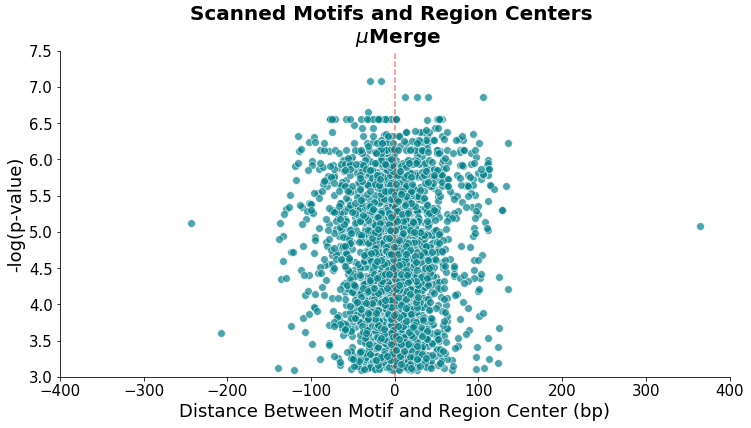

In [53]:
merge_samples_ids = ['Bedtools Intersect', 'Bedtools Merge', r'$\mu$Merge']

for dist, sig, label in zip(merge_distances, merge_motif_sig, merge_samples_ids):
  
    fig, ax0 = plt.subplots(figsize=(12, 6))

    ax08 = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color='#02818a', alpha=0.7)
    ax08.axvline(0, ls='--', color='red', linewidth=1.5, alpha=.5)
    ax08.set_title('Scanned Motifs and Region Centers \n {}'.format(label),
                 fontsize=20, fontweight='bold')
    ax08.set_xlabel('Distance Between Motif and Region Center (bp)',fontsize=18)
    ax08.set_ylabel('-log(p-value)',fontsize=18)
    ax08.spines['right'].set_visible(False)
    ax08.spines['top'].set_visible(False)
    plt.legend(prop={'size': 12}, title = '')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax08.set(xlim=(-400, 400))
    ax08.set(ylim=(3, 7.5))
    